# nearby galaxy catalog: 
<11 Mpc

https://ui.adsabs.harvard.edu/abs/2013AJ....145..101K/abstract
http://ciber0.rit.edu/~ciber/logbook/20190530_stackerr/

# Abell cluster cats
https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dabell&Action=More+Options
https://ui.adsabs.harvard.edu/abs/1958ApJS....3..211A/abstract

In [24]:
from utils import *
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord

def abell_add_xy(field, df):
    if len(df)==0:
        order = [c for c in df.columns]
        df['x1'] = []
        df['x2'] = []
        df['y1'] = []
        df['y2'] = []
        order = order[:3] + ['x1','y1','x2','y2'] + order[3:]
        dfout = df[order].copy()
        return df
    
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        bound = 511.5
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'x'+str(inst)] = df['xB']
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'y'+str(inst)] = df['yB']
        
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'x'+str(inst)] = df['xC']
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'y'+str(inst)] = df['yC']

        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'x'+str(inst)] = df['xD']
        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'y'+str(inst)] = df['yD']

    # write x, y to df
    order = order[:3] + ['x1','y1','x2','y2'] + order[3:]
    dfout = df[order].copy()
    
    return dfout

In [25]:
datadir = mypaths['ciberdir'] + 'doc/20170617_Stacking/maps/clustercats/'
df = pd.read_csv(datadir + 'abell_clusters.txt',
                 skiprows=2, sep='|')
df.drop(['Unnamed: 0', 'Unnamed: 10'],axis=1, inplace=True)
df.rename(columns=lambda x: x.strip(), inplace=True)
ra_arr = []
dec_arr = []
for sra, sdec in zip(df['ra'], df['dec']):
    ra_hr, ra_min = sra.split()
    ra = (np.float(ra_hr) + np.float(ra_min) / 60) * 15
    dec_int, dec_dec = sdec.split()
    dec = np.float(dec_int) +  np.sign(np.float(dec_int)) * np.float(dec_dec) / 100
    ra_arr.append(ra)
    dec_arr.append(dec)
df['ra'] = ra_arr
df['dec'] = dec_arr

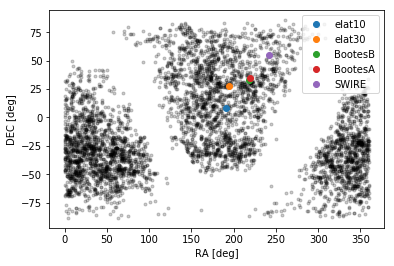

In [3]:
plt.plot(ra_arr, dec_arr, 'k.', alpha=0.2)
for ifield in [4,5,6,7,8]:
    ra_cent, dec_cent = field_center_dict[ifield]
    plt.plot(ra_cent, dec_cent, 'o', label=fieldnamedict[ifield])
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend()

# Cluster catalog
z = 0.05 (~ 200 Mpc) - 0.42

https://ui.adsabs.harvard.edu/abs/2012ApJS..199...34W/abstract

Fig.6 completeness function

elat10 ABELL1601  70
elat30 ABELL1641  79
elat30 ABELL1619  55
elat30 ABELL1628  57
elat30 ABELL1632  80
SWIRE ABELL2168  66
SWIRE ABELL2166  51


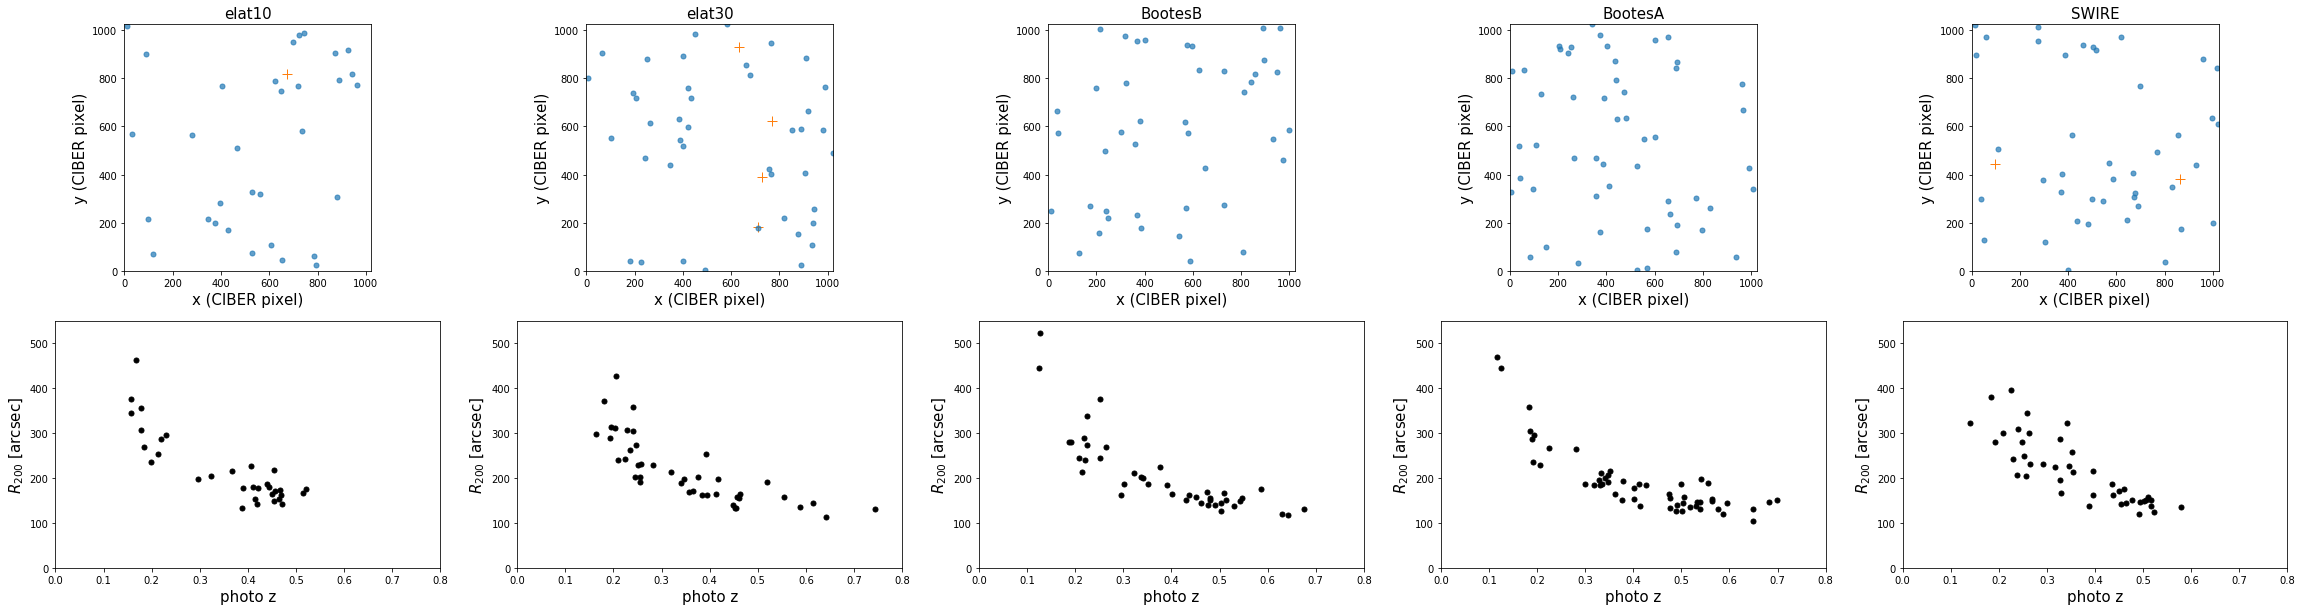

In [52]:
datadir = mypaths['ciberdir'] + 'doc/20170617_Stacking/maps/clustercats/'
fig, ax = plt.subplots(2,5,figsize=(40,10))
m_bins = np.arange(16,20)
for i,ifield in enumerate([4,5,6,7,8]): 
    field = fieldnamedict[ifield]
    dfc = pd.read_csv(datadir + field + '.csv')
    dfc = abell_add_xy(field, dfc)
    dfc = dfc[(dfc['x1']>-0.5) & (dfc['x1']<1023.5) & (dfc['y1']>-0.5) & (dfc['y1']<1023.5)]
    dfc['r200_arcsec'] = (cosmo.arcsec_per_kpc_proper(dfc['zph']) * dfc['r200'] * 1e3).value
    
    ra_cent, dec_cent = field_center_dict[ifield]
    dfa = df[(df['ra']>ra_cent-2) & (df['ra']<ra_cent+2) & \
             (df['dec']>dec_cent-2) & (df['dec']<dec_cent+2)].copy()
    dfa = abell_add_xy(field, dfa)
    dfa = dfa[(dfa['x1']>0) & (dfa['x1']<1024) & \
             (dfa['x2']>0) & (dfa['x2']<1024)].copy()
    dfa.drop(['bmtype','rich','dist'],axis=1,inplace=True)
    if len(dfa)>0:
        for name,count in zip(dfa['name'],dfa['_count']):
            print(field, name, count)
        
    ax[0][i].plot(dfa['x1'], dfa['y1'],'C1+', markersize=10)
    ax[0][i].plot(dfc['x1'],dfc['y1'], 'C0.',markersize=10,alpha=0.7)
    ax[0][i].set_title(field, fontsize = 15)
    ax[0][i].set_xlabel('x (CIBER pixel)', fontsize = 15)
    ax[0][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[0][i].set_xlim([-0.5, 1023.5])
    ax[0][i].set_ylim([-0.5, 1023.5])
    ax[0][i].set_aspect('equal')

    ax[1][i].plot(dfc['zph'],dfc['r200_arcsec'], 'k.', markersize = 10)
    ax[1][i].set_ylabel('y (CIBER pixel)', fontsize = 15)
    ax[1][i].set_xlabel('photo z', fontsize = 15)
    ax[1][i].set_ylabel('$R_{200}$ [arcsec]', fontsize = 15)
    ax[1][i].set_xlim([0,0.8])
    ax[1][i].set_ylim([0,550])
# plt.savefig('clusters.png')

# 2MASS Extended
https://iopscience.iop.org/article/10.1086/301330/pdf

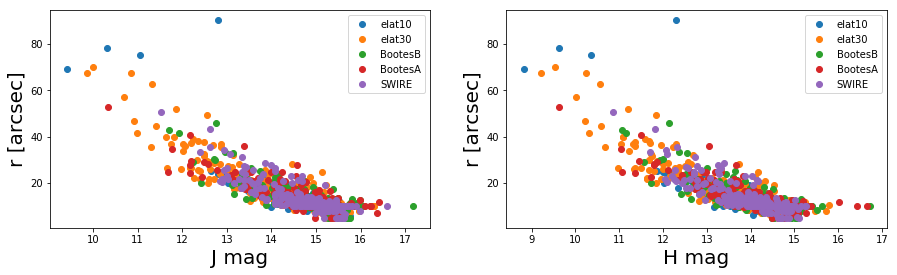

In [55]:
inst = 1
catcoorddir = mypaths['ciberdir'] + 'doc/20170617_Stacking/maps/2masscats/XSC/'

fig, ax = plt.subplots(1,2,figsize=(15,4))
for i,field in enumerate(['elat10','elat30','BootesB','BootesA','SWIRE']): 
    fname = catcoorddir+ field + '.tbl'
    data = np.loadtxt(fname, skiprows=38, usecols=(0,1,2,3,5,7))
    df = pd.DataFrame(data, columns=['ra', 'dec', 'r_ext', 'j', 'h', 'k'])
    df = abell_add_xy(field, df)
    df = df[(df['x1']>-0.5) & (df['x1']<1023.5) & (df['y1']>-0.5) & (df['y1']<1023.5)]
    ax[0].plot(df['j'],df['r_ext'],'o',label=field)
    ax[1].plot(df['h'],df['r_ext'],'o',label=field)

ax[0].set_xlabel('J mag', fontsize = 20)
ax[0].set_ylabel('r [arcsec]', fontsize = 20)
ax[1].set_xlabel('H mag', fontsize = 20)
ax[1].set_ylabel('r [arcsec]', fontsize = 20)

ax[0].legend()
ax[1].legend()